### 1. Set up the environment

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"

In [39]:
import torch
import yaml
import librosa
import pysptk
import numpy as np
import torch.nn.functional as F
from models import ModelCollection
from datasets import MelDataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### 2. Load necessary configurations

In [3]:
# read configs
preprocess_config = yaml.load(open("./configs/VCTK/preprocess.yaml", "r"), Loader=yaml.FullLoader)
model_config = yaml.load(open("./configs/VCTK/model.yaml", "r"), Loader=yaml.FullLoader)
train_config = yaml.load(open("./configs/VCTK/train.yaml", "r"), Loader=yaml.FullLoader)
sampling_rate = preprocess_config["preprocessing"]["audio"]["sampling_rate"]
hop_length = preprocess_config["preprocessing"]["stft"]["hop_length"]
exp_name = "output-CCDPJ-c_100.0_1.3-s_10.0_60.0-p_10.0_3.0"
ckpt_path = os.path.join(exp_name, train_config["path"]["ckpt_path"], "{}.pth.tar".format(200000))
assert os.path.isfile(ckpt_path)

### 3. Set up audio feature extractor

In [5]:
import audio as Audio
mel_extractor = Audio.MelExtractor(
    n_fft=preprocess_config["preprocessing"]["mel_hg"]["n_fft"],
    num_mels=preprocess_config["preprocessing"]["mel_hg"]["num_mels"],
    hop_size=preprocess_config["preprocessing"]["mel_hg"]["hop_size"],
    win_size=preprocess_config["preprocessing"]["mel_hg"]["win_size"],
    sampling_rate=preprocess_config["preprocessing"]["mel_hg"]["sampling_rate"],
    fmin=preprocess_config["preprocessing"]["mel_hg"]["fmin"],
    fmax=preprocess_config["preprocessing"]["mel_hg"]["fmax"],
    top_db=preprocess_config["preprocessing"]["sil_top_db"])

test_set = MelDataset(preprocess_config, 'test')


def f0_ene_extract(wav_arr):

    wav_arr = wav_arr / np.max(np.abs(wav_arr))
    wav_arr = librosa.util.normalize(wav_arr) * 0.95

    lf0 = Audio.tools.logf0(
        wav_arr, lower_f0=preprocess_config["preprocessing"]["lower_f0"],
        upper_f0=preprocess_config["preprocessing"]["upper_f0"],
        sample_rate=preprocess_config["preprocessing"]["audio"]["sampling_rate"],
        frame_shift_sample=preprocess_config["preprocessing"]["stft"]["hop_length"]
    )

    f0 = np.where(lf0==0, 0., np.exp(lf0))

    energy = librosa.feature.rms(
        y=wav_arr,
        frame_length=preprocess_config["preprocessing"]["mel_hg"]["win_size"],
        hop_length=preprocess_config["preprocessing"]["mel_hg"]["hop_size"],
    )[0]

    return f0, energy


def feature_extract(wav_path):

    mel, wav = mel_extractor(wav_path)

    lf0 = Audio.tools.logf0(
        wav, lower_f0=preprocess_config["preprocessing"]["lower_f0"],
        upper_f0=preprocess_config["preprocessing"]["upper_f0"],
        sample_rate=preprocess_config["preprocessing"]["audio"]["sampling_rate"],
        frame_shift_sample=preprocess_config["preprocessing"]["stft"]["hop_length"]
    )

    f0 = np.where(lf0==0, 0., np.exp(lf0))

    energy = librosa.feature.rms(
        y=wav,
        frame_length=preprocess_config["preprocessing"]["mel_hg"]["win_size"],
        hop_length=preprocess_config["preprocessing"]["mel_hg"]["hop_size"],
    )

    lf0_quant = test_set.lf0_quantize(lf0)

    energy_quant = test_set.ene_quantize(energy)

    return wav, mel, f0, energy, lf0_quant, energy_quant

### 4. Load pretrained vocoder and model

In [6]:
# load Hifi-GAN vocoder
from utils import vocoder_infer, get_vocoder
vocoder = get_vocoder(model_config, device)

# load model
ckpt = torch.load(ckpt_path, map_location=device)
model = ModelCollection['CCDPJ'](preprocess_config, model_config, device).to(device)
model.load_state_dict(ckpt["model"])
model.eval()

Removing weight norm...


VAECCDPJ(
  (speaker_posterior): TIVConvEncoder(
    (conv_initial): Conv1d(80, 256, kernel_size=(1,), stride=(1,))
    (conv_layers): ModuleList(
      (0): DownSampleEncBlk(
        (layer_norm0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (conv1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (layer_norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (conv2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv_sc): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
        (downsample): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
      )
      (1): DownSampleEncBlk(
        (layer_norm0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (conv1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (layer_norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (conv2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv_sc): 

### 5. Some generation utils.

In [7]:
def to_one_hot(x):
    inds = x
    one_hot = np.zeros((inds.size, inds.max() + 1))
    one_hot[np.arange(inds.size), inds] = 1
    return one_hot.T

def generate(z_con, z_spk, pit_idx, ene_idx, lens):
    z_pit = model.prosody_posterior.pitch_embed(pit_idx)
    z_ene = model.prosody_posterior.energy_embed(ene_idx)
    time_len = z_con.size(2)
    z_spk = z_spk.unsqueeze(2).expand(-1, -1, time_len)
    dec_in = torch.cat([z_con, z_spk, z_pit, z_ene], dim=1)
    x_hat = model.decoder(dec_in, lens)
    return x_hat

### 6. Read the original wav and the speaker reference wav

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

In [103]:
org_wav_path = "p245_237_mic1.flac"
spk_wav_path = "p294_047_mic1.flac"

org_wav, org_mel_npy, _, _, org_lf0_q_npy, org_ene_q_npy = feature_extract(org_wav_path)
spk_wav, spk_mel_npy, _, _, _, _ = feature_extract(spk_wav_path)

print("Original speech:")
ipd.display(ipd.Audio(org_wav, rate=sampling_rate))

print("Speaker reference speech:")
ipd.display(ipd.Audio(spk_wav, rate=sampling_rate))

/mnt/users/hccl.local/luhui/projects/SpeechTripleNet/audio/utils.py:56: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=80, fmin=0, fmax=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa_mel_fn(sampling_rate, n_fft, num_mels, fmin, fmax)


Original speech:


Speaker reference speech:


### 7. Extract features from the waveforms, obtain the latent representations

Reconstrcuted speech:


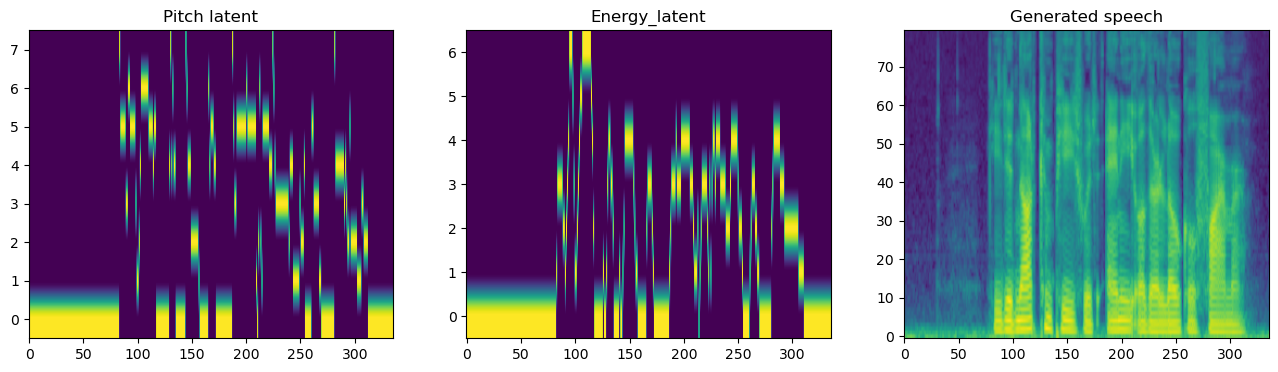

In [104]:
org_mel = torch.from_numpy(org_mel_npy).unsqueeze(0).to(device)
org_len = torch.LongTensor([org_mel.size(2)]).to(device)
# do reconstruction
con_mu, con_log_std = model.content_posterior(org_mel, org_len)
org_spk_mel = org_mel
while org_spk_mel.size(2) < preprocess_config["preprocessing"]["segment_size"]:
    org_spk_mel = torch.cat([org_spk_mel, org_spk_mel], dim=2)
org_spk_mel = org_spk_mel[:, :, :preprocess_config["preprocessing"]["segment_size"]]
spk_mu, spk_log_std = model.speaker_posterior(org_mel)
z_con = model.content_posterior.sample(con_mu, con_log_std)
z_spk = model.speaker_posterior.sample(spk_mu, spk_log_std)
prosody_logits, z_pit, z_ene = model.prosody_posterior(org_mel)
pro_probs = F.softmax(prosody_logits, dim=1).permute(0, 2, 1).reshape(z_pit.size(0), z_pit.size(2), 8, 8)
# compute marginal for energy
ene_probs = torch.sum(pro_probs, dim=2)
ene_idx = torch.argmax(ene_probs, dim=2)
# compute marginal for pitch
pit_probs = torch.sum(pro_probs, dim=3)
pit_idx = torch.argmax(pit_probs, dim=2)
recon_mel = generate(z_con, z_spk, pit_idx, ene_idx, org_len)
hop_length = preprocess_config["preprocessing"]["mel_hg"]["hop_size"]
wav_lens = org_len * hop_length
recon_wav = vocoder_infer(recon_mel, vocoder, model_config, preprocess_config, wav_lens)
print("Reconstrcuted speech:")
ipd.display(ipd.Audio(recon_wav, rate=sampling_rate))

T = org_len.detach().cpu().numpy()[0]
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

ax[0].set_title('Pitch latent')
ax[1].set_title('Energy_latent')
ax[2].set_title('Generated speech')

# reconstructed speech
ax[0].imshow(to_one_hot(pit_idx.cpu().numpy()), origin='lower', aspect="auto")
ax[1].imshow(to_one_hot(ene_idx.cpu().numpy()), origin='lower', aspect="auto")
ax[2].imshow(org_mel.squeeze(0).detach().cpu().numpy(), origin='lower', aspect="auto")

plt.show()

In [105]:
# Find out all voiced segments for editting according to the pitch latent.
# Each line represents roughly a voiced segment of the speech
prev_0 = False
for i, p in enumerate(pit_idx.cpu().numpy()[0]):
    if p == 0:
        if not prev_0:
            print()
            prev_0 = True
        continue
    else:
        print((i, p), end=' ')
        prev_0 = False


(83, 7) (84, 5) (85, 5) (86, 5) (87, 5) (88, 5) (89, 3) (90, 3) (91, 6) (92, 6) (93, 5) (94, 5) (95, 5) (96, 5) (97, 5) (98, 3) (99, 1) (100, 1) (101, 2) (102, 4) (103, 6) (104, 6) (105, 6) (106, 6) (107, 6) (108, 6) (109, 6) (110, 5) (111, 5) (112, 5) (113, 5) (114, 4) (115, 5) (116, 5) 
(129, 4) (130, 7) (131, 4) (132, 6) (133, 4) (134, 4) 
(144, 7) (145, 6) (146, 4) (147, 4) (148, 4) (149, 2) (150, 2) (151, 2) (152, 2) (153, 2) (154, 2) (155, 2) (156, 1) 
(165, 6) (166, 4) (167, 5) (168, 5) (169, 5) (170, 4) (171, 4) 
(187, 7) (188, 5) (189, 3) (190, 3) (191, 5) (192, 5) (193, 5) (194, 5) (195, 5) (196, 5) (197, 5) (198, 5) (199, 5) (200, 6) (201, 5) (202, 5) (203, 5) (204, 5) (205, 5) (206, 5) (207, 5) (208, 5) (209, 1) 
(211, 2) (212, 6) (213, 2) (214, 1) (215, 5) (216, 5) (217, 5) (218, 5) (219, 5) (220, 5) (221, 4) (222, 4) (223, 4) (224, 7) (225, 6) (226, 4) (227, 3) (228, 3) (229, 3) (230, 3) (231, 3) (232, 3) (233, 3) (234, 3) (235, 3) (236, 3) (237, 3) (238, 3) (239, 2) (24

In [108]:
# Extract speaker representation
spk_mel = torch.from_numpy(spk_mel_npy).unsqueeze(0).to(device)
while spk_mel.size(2) < preprocess_config["preprocessing"]["segment_size"]:
    spk_mel = torch.cat([spk_mel, spk_mel], dim=2)
ref_spk_mu, ref_spk_log_std = model.speaker_posterior(spk_mel)
z_spk_ref = model.speaker_posterior.sample(ref_spk_mu, ref_spk_log_std)

### 8.Conduct speech editting

In [109]:
idx1 = 281  # here we choose the last voiced segment for editing
idx2 = 312  # it roughly corresponds to the word "farmer"
print('Editing timbre:')
mel_spk = generate(z_con, z_spk_ref, pit_idx, ene_idx, org_len)
spk_wav = vocoder_infer(mel_spk, vocoder, model_config, preprocess_config, wav_lens)[0]
ipd.display(ipd.Audio(spk_wav, rate=sampling_rate))

print('Editing pitch:')
mod_pit_npy = pit_idx.detach().cpu().numpy()[0]
mod_pit_npy[idx1:idx2] = 7
mod_pit = torch.from_numpy(mod_pit_npy).unsqueeze(0).to(device)
mel_pit = generate(z_con, z_spk, mod_pit, ene_idx, org_len)
pit_wav = vocoder_infer(mel_pit, vocoder, model_config, preprocess_config, wav_lens)[0]
ipd.display(ipd.Audio(pit_wav, rate=sampling_rate))

print('Editing energy:')
mod_ene_npy = ene_idx.detach().cpu().numpy()[0]
mod_ene_npy[idx1:idx2] = 7
mod_ene = torch.from_numpy(mod_ene_npy).unsqueeze(0).to(device)
mel_ene = generate(z_con, z_spk, pit_idx, mod_ene, org_len)
ene_wav = vocoder_infer(mel_ene, vocoder, model_config, preprocess_config, wav_lens)[0]
ipd.display(ipd.Audio(ene_wav, rate=sampling_rate))

print('Editing pitch and energy:')
mel_pit_ene = generate(z_con, z_spk, mod_pit, mod_ene, org_len)
ep_wav = vocoder_infer(mel_pit_ene, vocoder, model_config, preprocess_config, wav_lens)[0]
ipd.display(ipd.Audio(ep_wav, rate=sampling_rate))

print('Editing speaker, pitch and energy:')
emp_mel_spk = generate(z_con, z_spk_ref, mod_pit, mod_ene, org_len)
emp_spk_wav = vocoder_infer(emp_mel_spk, vocoder, model_config, preprocess_config, wav_lens)[0]
ipd.display(ipd.Audio(emp_spk_wav, rate=sampling_rate))

Editing timbre:


Editing pitch:


Editing energy:


Editing pitch and energy:


Editing speaker, pitch and energy:


### 9. Extract pitch, energy from the editted speech and visualize the modification

In [101]:
org_pit, org_ene = f0_ene_extract(np.array(org_wav))
spk_pit, spk_ene = f0_ene_extract(np.array(spk_wav))
pit_pit, pit_ene = f0_ene_extract(np.array(pit_wav))
ene_pit, ene_ene = f0_ene_extract(np.array(ene_wav))
ep_pit, ep_ene = f0_ene_extract(np.array(ep_wav))
max_pit = max(org_pit.tolist() + spk_pit.tolist() + pit_pit.tolist() + ene_pit.tolist() + ep_pit.tolist())
max_ene = max(org_ene.tolist() + spk_ene.tolist() + pit_ene.tolist() + ene_ene.tolist() + ep_ene.tolist())

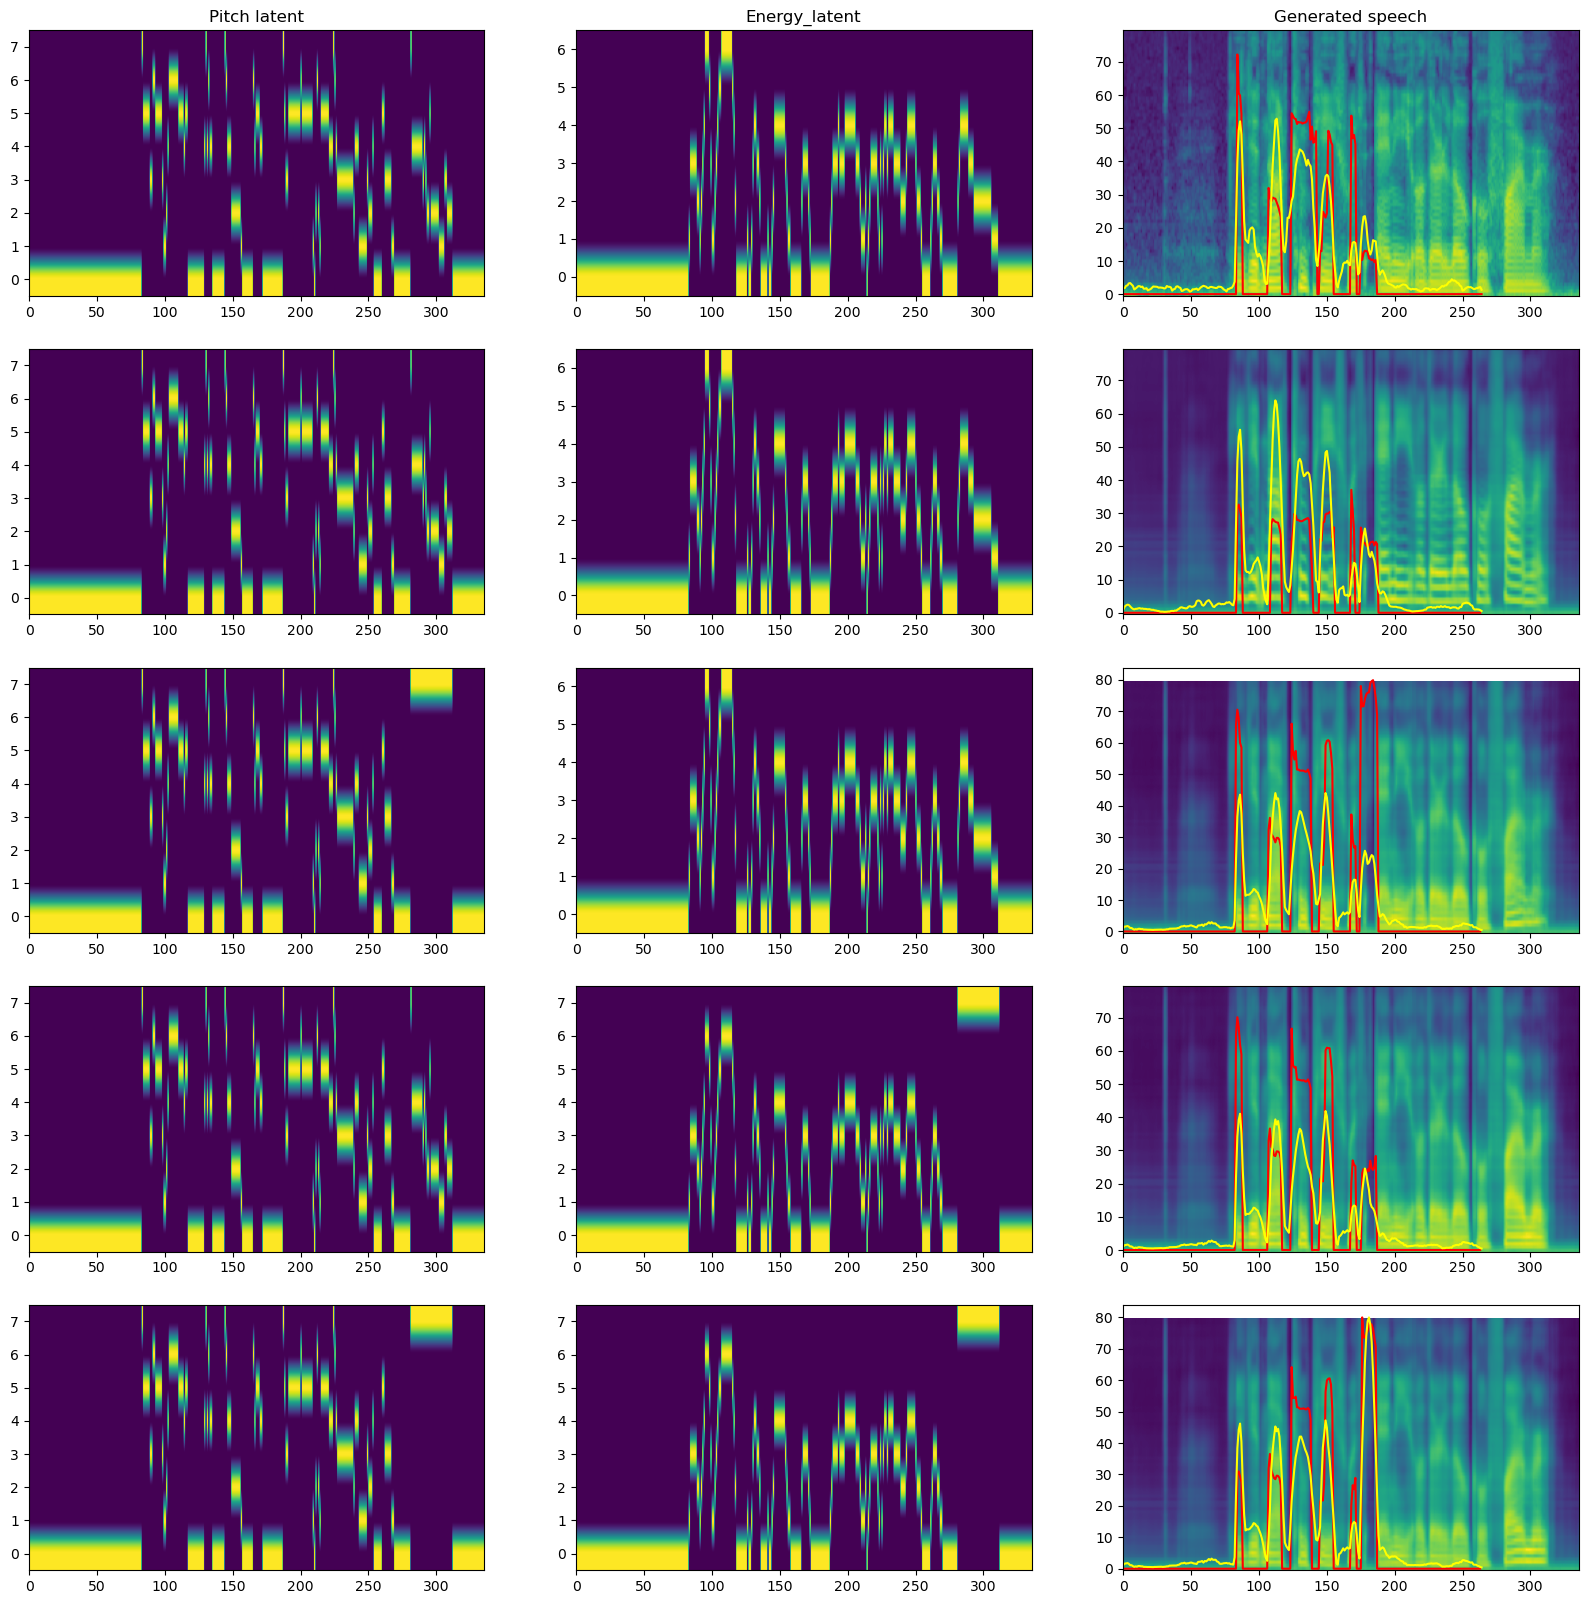

In [110]:
T = org_len.detach().cpu().numpy()[0]
fig, ax = plt.subplots(5, 3, figsize=(20, 20))

ax[0][0].set_title('Pitch latent')
ax[0][1].set_title('Energy_latent')
ax[0][2].set_title('Generated speech')

# reconstructed speech
ax[0][0].imshow(to_one_hot(pit_idx.cpu().numpy()), origin='lower', aspect="auto")
ax[0][1].imshow(to_one_hot(ene_idx.cpu().numpy()), origin='lower', aspect="auto")
ax[0][2].imshow(org_mel.squeeze(0).detach().cpu().numpy(), origin='lower', aspect="auto")
ax[0][2].plot(org_pit[:T] * 80 / max_pit, color='red')
ax[0][2].plot(org_ene[:T] * 80 / max_ene, color='yellow')

# speaker-editted speech
ax[1][0].imshow(to_one_hot(pit_idx.cpu().numpy()), origin='lower', aspect="auto")
ax[1][1].imshow(to_one_hot(ene_idx.cpu().numpy()), origin='lower', aspect="auto")
ax[1][2].imshow(mel_spk.squeeze(0).detach().cpu().numpy(), origin='lower', aspect="auto")
ax[1][2].plot(spk_pit[:T] * 80 / max_pit, color='red')
ax[1][2].plot(spk_ene[:T] * 80 / max_ene, color='yellow')

# pitch-editted speech
ax[2][0].imshow(to_one_hot(mod_pit_npy), origin='lower', aspect="auto")
ax[2][1].imshow(to_one_hot(ene_idx.cpu().numpy()), origin='lower', aspect="auto")
ax[2][2].imshow(mel_pit.squeeze(0).detach().cpu().numpy(), origin='lower', aspect="auto")
ax[2][2].plot(pit_pit[:T] * 80 / max_pit, color='red')
ax[2][2].plot(pit_ene[:T] * 80 / max_ene, color='yellow')

# energy-editted speech
ax[3][0].imshow(to_one_hot(pit_idx.cpu().numpy()), origin='lower', aspect="auto")
ax[3][1].imshow(to_one_hot(mod_ene_npy), origin='lower', aspect="auto")
ax[3][2].imshow(mel_ene.squeeze(0).detach().cpu().numpy(), origin='lower', aspect="auto")
ax[3][2].plot(ene_pit[:T] * 80 / max_pit, color='red')
ax[3][2].plot(ene_ene[:T] * 80 / max_ene, color='yellow')

# pitch and energy-editted speech
ax[4][0].imshow(to_one_hot(mod_pit_npy), origin='lower', aspect="auto")
ax[4][1].imshow(to_one_hot(mod_ene_npy), origin='lower', aspect="auto")
ax[4][2].imshow(mel_pit_ene.squeeze(0).detach().cpu().numpy(), origin='lower', aspect="auto")
ax[4][2].plot(ep_pit[:T] * 80 / max_pit, color='red')
ax[4][2].plot(ep_ene[:T] * 80 / max_ene, color='yellow')
plt.show()